In [2]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy.sparse import hstack
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from nltk.corpus import stopwords
from sklearn.svm import LinearSVC
from nltk.stem.porter import PorterStemmer
from sklearn import metrics, svm
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn import utils
from sklearn.svm import SVR

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
pd.options.mode.chained_assignment = None 
df = pd.read_csv("../data/winemag-data_first150k.csv", nrows=50000,index_col=0)
df.head()

,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


In [4]:
#drop columns not needed
df = df.drop(['designation','province','region_1','region_2','winery'], axis = 1)

#We will now test for duplictes in the dataset to ensure that we are using unique reviews
df[df.duplicated('description',keep=False)].head()

#We will now remove the dulicates based on the descripton column 
df = df.drop_duplicates('description')
df.head()

,country,description,points,price,variety
0,US,This tremendous 100% varietal wine hails from ...,96,235.0,Cabernet Sauvignon
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",96,110.0,Tinta de Toro
2,US,Mac Watson honors the memory of a wine once ma...,96,90.0,Sauvignon Blanc
3,US,"This spent 20 months in 30% new French oak, an...",96,65.0,Pinot Noir
4,France,"This is the top wine from La Bégude, named aft...",95,66.0,Provence red blend


In [5]:
df.apply(lambda x: sum(x.isnull()),axis=0)

country           2
description       0
points            0
price          4102
variety           0
dtype: int64

In [6]:
df['price'].fillna(df['price'].mean(), inplace=True)

#Return a sum count of rows with missing data
df.apply(lambda x: sum(x.isnull()),axis=0) 

country        2
description    0
points         0
price          0
variety        0
dtype: int64

In [7]:
df.dropna(axis='rows',inplace=True)

#Return a sum count of rows with missing data
df.apply(lambda x: sum(x.isnull()),axis=0) 

country        0
description    0
points         0
price          0
variety        0
dtype: int64

In [8]:
stopword_list = stopwords.words('english')
ps = PorterStemmer()
for i in range(0,len(df['description'])):
    try:
        description = re.sub('[^a-zA-Z]',' ',df['description'][i])
        description = description.lower().strip()
        description_words = description.split()
        description_words = [word for word in description_words if not word in stopword_list]
        description_words = [ps.stem(word) for word in description_words]
        df['description'][i] = ' '.join(description_words)
    except:
        pass

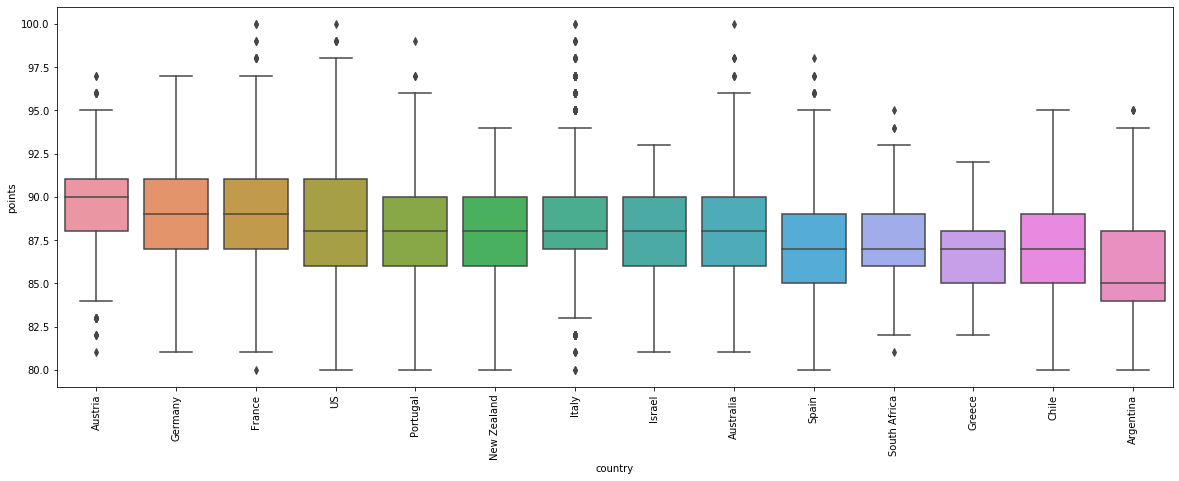

In [9]:
country=df.groupby('country').filter(lambda x: len(x) >100)
df1 = pd.DataFrame({col:vals['points'] for col,vals in country.groupby('country')})
meds = df1.median()
meds.sort_values(ascending=False, inplace=True)

fig, ax = plt.subplots(figsize = (20,7))
chart = sns.boxplot(x='country',y='points', data=country, order=meds.index, ax = ax)
plt.xticks(rotation = 90)

plt.show()

C:\Users\Stefan\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  


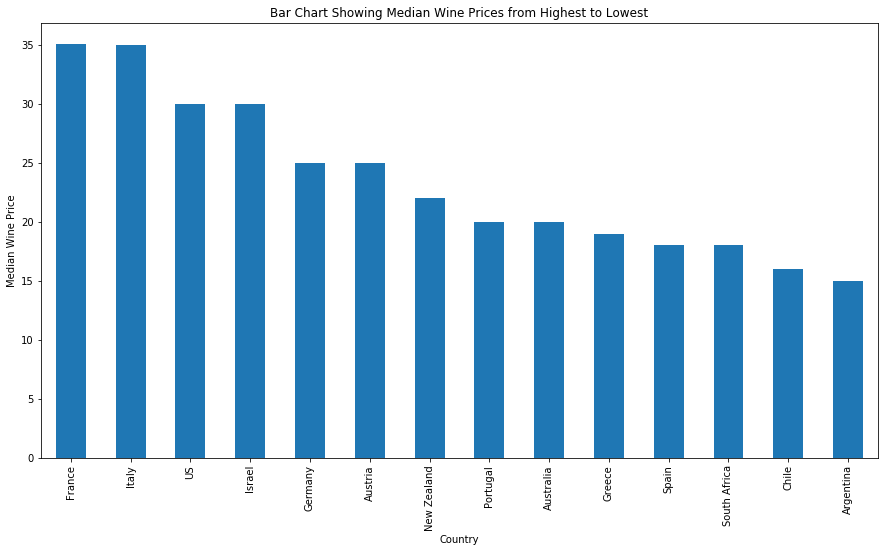

In [10]:
df2 = pd.DataFrame({col:vals['price'] for col,vals in country.groupby('country')})
meds2 = df2.median()
meds2 = meds2.sort_values(ascending=False)

plt.rcParams['figure.figsize']=15,8 
meds2.plot("bar")
plt.title('Bar Chart Showing Median Wine Prices from Highest to Lowest')
plt.xlabel('Country')
plt.ylabel('Median Wine Price')
plt.show()

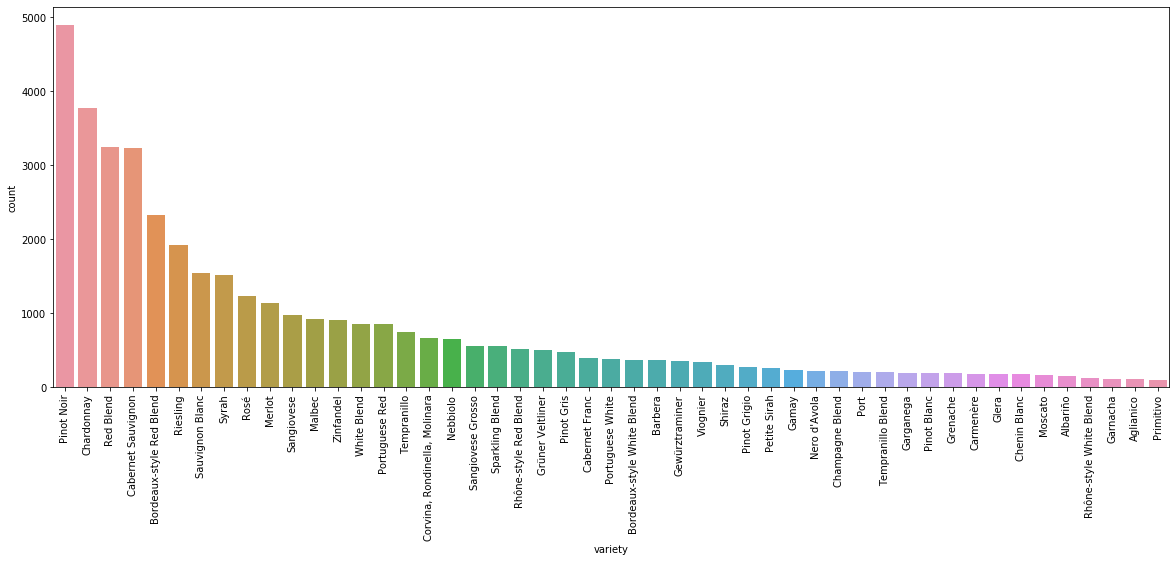

In [11]:
df = df.groupby('variety').filter(lambda x: len(x) >100)
list = df.variety.value_counts().index.tolist()
fig4, ax4 = plt.subplots(figsize = (20,7))
sns.countplot(x='variety', data=df, order = list, ax=ax4)
plt.xticks(rotation = 90)
plt.show()

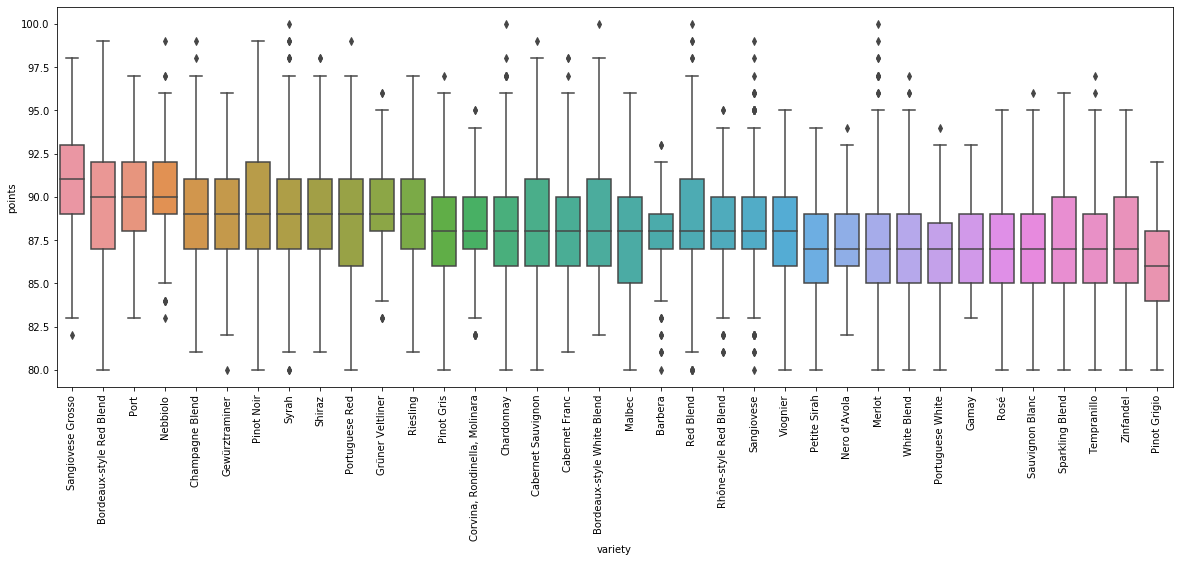

In [12]:
df = df.groupby('variety').filter(lambda x: len(x) >200)

df3 = pd.DataFrame({col:vals['points'] for col,vals in df.groupby('variety')})
meds3 = df3.median()
meds3.sort_values(ascending=False, inplace=True)

fig3, ax3 = plt.subplots(figsize = (20,7))
chart = sns.boxplot(x='variety',y='points', data=df, order=meds3.index, ax = ax3)
plt.xticks(rotation = 90)
plt.show()

C:\Users\Stefan\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  


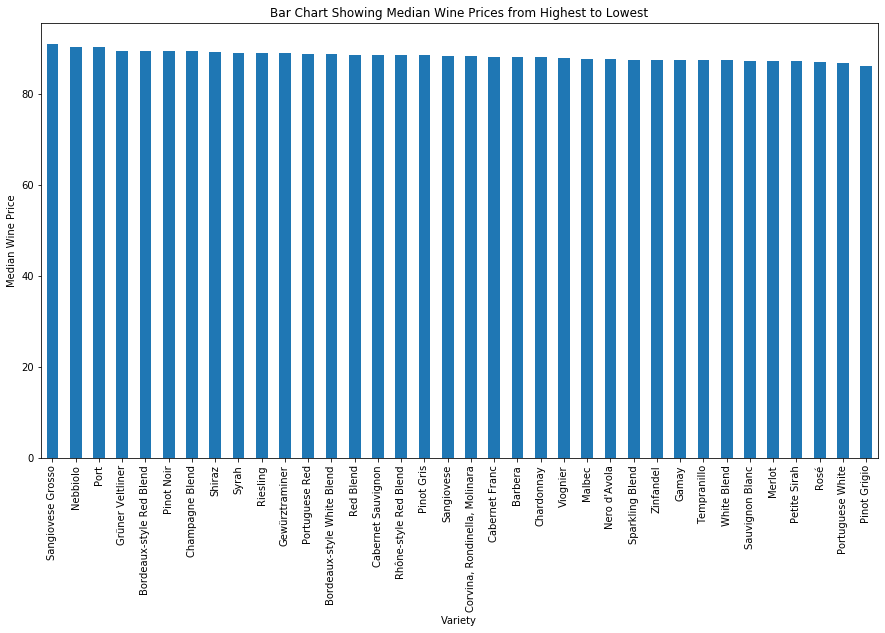

In [13]:
df4 = pd.DataFrame({col:vals['points'] for col,vals in df.groupby('variety')})
mean1 = df4.mean()
mean1 = mean1.sort_values(ascending=False)

plt.rcParams['figure.figsize']=15,8 
mean1.plot("bar")
plt.title('Bar Chart Showing Median Wine Prices from Highest to Lowest')
plt.xlabel('Variety')
plt.ylabel('Median Wine Price')
plt.show()

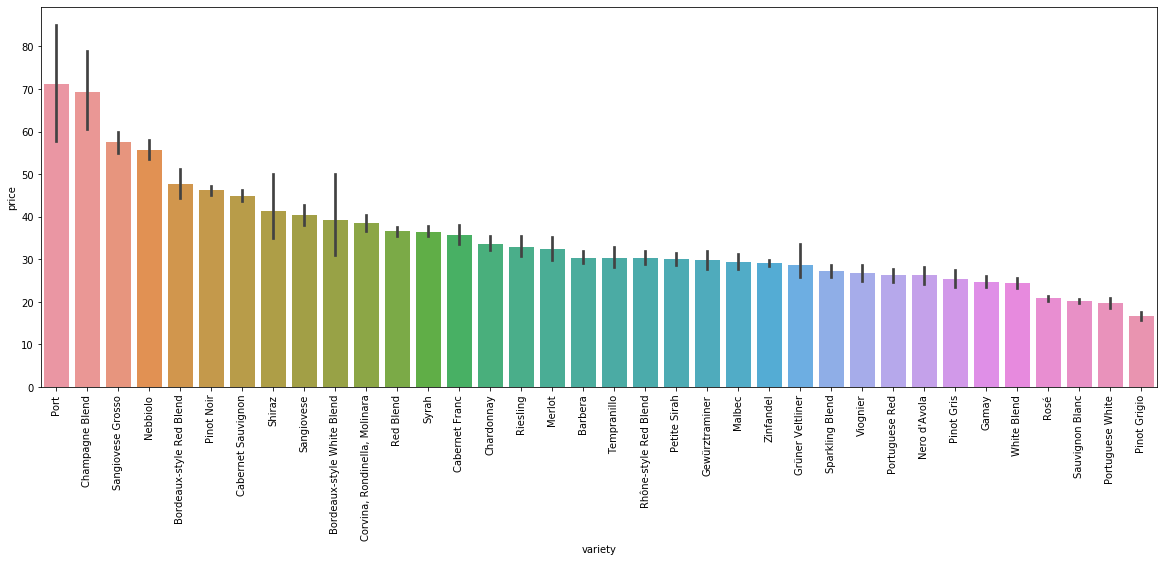

In [14]:
df5 = pd.DataFrame({col:vals['price'] for col,vals in df.groupby('variety')})
mean2 = df5.mean()
mean2.sort_values(ascending=False, inplace=True)

fig3, ax3 = plt.subplots(figsize = (20,7))
chart = sns.barplot(x='variety',y='price', data=df, order=mean2.index, ax = ax3)
plt.xticks(rotation = 90)
plt.show()

# Support-Vector Machine (SVM)

In [15]:
filtered = df.groupby('variety').filter(lambda x: len(x) >= 500) #taking only the highest occuring to reduce size and keeping distribution in mind.

In [16]:
#Making a new column that is encoded version of variety
filtered['variety_id'] = filtered['variety'].factorize()[0]
category_id_df = filtered[['variety', 'variety_id']].drop_duplicates().sort_values('variety_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['variety_id', 'variety']].values)

filtered.head()

,country,description,points,price,variety,variety_id
0,US,tremend variet wine hail oakvil age three year...,96,235.0,Cabernet Sauvignon,0
2,US,mac watson honor memori wine made mother treme...,96,90.0,Sauvignon Blanc,1
3,US,spent month new french oak incorpor fruit ponz...,96,65.0,Pinot Noir,2
8,US,name vineyard formerli bottl delancellotti fin...,95,65.0,Pinot Noir,2
9,US,produc sourc two block vineyard wine one high ...,95,60.0,Pinot Noir,2


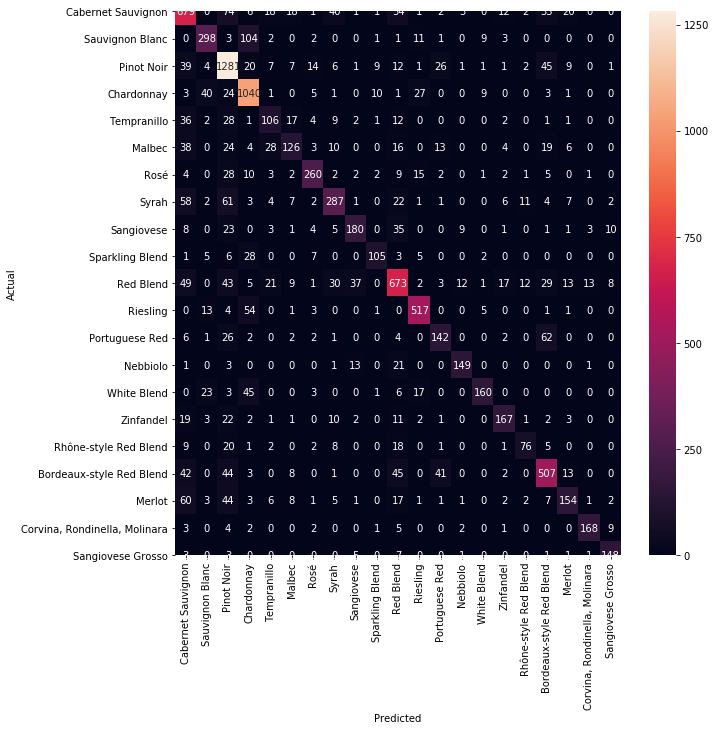

In [17]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='UTF-8', ngram_range=(1, 2), stop_words='english') 

features = tfidf.fit_transform(filtered.description).toarray() #Removing Stop words from descriptions 
labels = filtered.variety_id #Varity Numberical values saved as labels

model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, filtered.index, test_size=0.30, random_state=0) #70/30 Split
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=category_id_df.variety.values, yticklabels=category_id_df.variety.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [18]:
X = df.drop('country', axis=1)  
y = df['points']

In [19]:
X = category_id_df.drop('variety_id', axis=1)  
y = category_id_df['variety_id'] 
category_id_df.head()

,variety,variety_id
0,Cabernet Sauvignon,0
2,Sauvignon Blanc,1
3,Pinot Noir,2
15,Chardonnay,3
17,Tempranillo,4


In [20]:
#Droping the duplicates
df[df.duplicated('description',keep=False)].sort_values('description').head(5)

,country,description,points,price,variety
13189,US,blend viognier grenach fragrant offer display ...,91,35.0,Syrah
30964,US,blend viognier grenach fragrant offer display ...,92,32.0,Syrah


In [21]:
df = df.drop_duplicates('description')
df = df[pd.notnull(df.price)]
df.shape

(37872, 5)

Pearson Correlation: (0.39961983961201186, 0.0)
                                 OLS Regression Results                                
Dep. Variable:                 points   R-squared (uncentered):                   0.437
Model:                            OLS   Adj. R-squared (uncentered):              0.437
Method:                 Least Squares   F-statistic:                          2.938e+04
Date:                Wed, 15 Jan 2020   Prob (F-statistic):                        0.00
Time:                        14:53:24   Log-Likelihood:                     -2.1263e+05
No. Observations:               37872   AIC:                                  4.253e+05
Df Residuals:                   37871   BIC:                                  4.253e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      

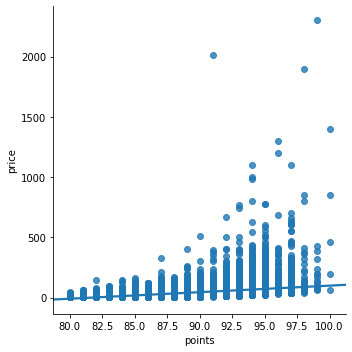

In [22]:
from scipy.stats import pearsonr
import statsmodels.api as sm
print("Pearson Correlation:", pearsonr(df.price, df.points))
print(sm.OLS(df.points, df.price).fit().summary())
sns.lmplot(y = 'price', x='points', data=df)

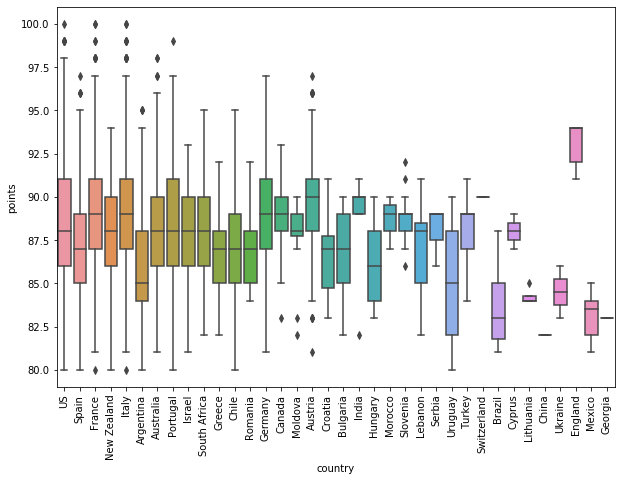

In [23]:
fig, ax = plt.subplots(figsize = (10,7))
chart = sns.boxplot(x='country',y='points', data=df, ax = ax)
plt.xticks(rotation = 90)
plt.show()

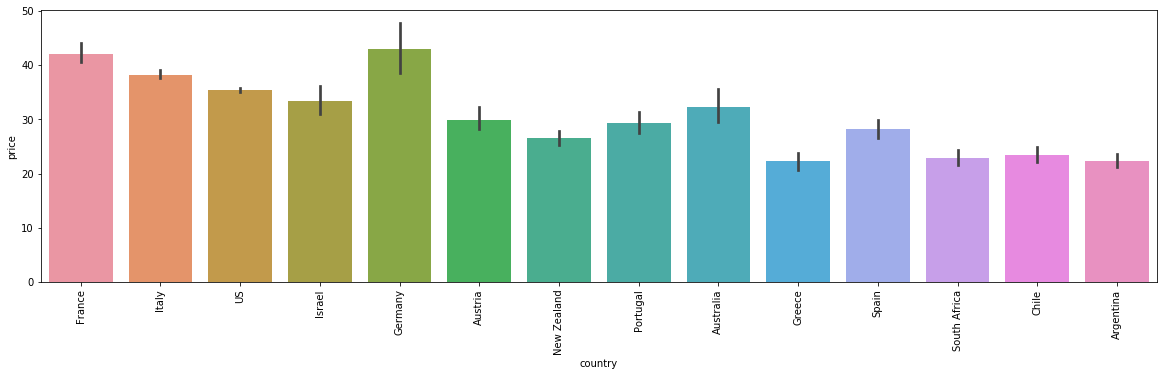

In [24]:
df6 = pd.DataFrame({col:vals['price'] for col,vals in country.groupby('country')})
meds2 = df6.median()
meds2.sort_values(ascending=False, inplace=True)

fig, ax = plt.subplots(figsize = (20,5))
chart = sns.barplot(x='country',y='price', data=country, order=meds2.index, ax = ax)
plt.xticks(rotation = 90)
plt.show()

In [25]:
df = df.reset_index()

In [26]:
X = df.drop(['country','description','variety'], axis = 1)
y = df.price

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(28404, 3) (9468, 3) (28404,) (9468,)


In [27]:
X = X.as_matrix().astype(np.float)
y = y.as_matrix().astype(np.float)

C:\Users\Stefan\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
C:\Users\Stefan\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [28]:
df.apply(lambda x: sum(x.isnull()),axis=0)

index          0
country        0
description    0
points         0
price          0
variety        0
dtype: int64

In [29]:
classifier = svm.SVR(kernel='linear') # We set a SVM classifier, the default SVM Classifier (Kernel = Radial Basis Function)

In [30]:
lab_enc = preprocessing.LabelEncoder()
training_scores_encoded = lab_enc.fit_transform(y_train)
print(training_scores_encoded)
print(utils.multiclass.type_of_target(y_train))
print(utils.multiclass.type_of_target(y_train.astype('int')))
print(utils.multiclass.type_of_target(training_scores_encoded))

[12 12 32 ... 92 10 72]
continuous
multiclass
multiclass


In [31]:
classifier.fit(X_train, y_train) # Then we train our model, with our balanced data train.

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='linear', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [32]:
from sklearn.model_selection import train_test_split  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.60) 

In [33]:
from sklearn.svm import SVR  
svclassifier = SVR(kernel='linear')  
svclassifier.fit(X_train, y_train) 

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='linear', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [34]:
y_pred = svclassifier.predict(X_test) 

In [35]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
clf = RandomForestRegressor(n_estimators=10)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy Score:',clf.score(X_test, y_test) *100,"%")

Accuracy Score: 97.32331516764926 %
